# Import the required libraries

In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint
import spacy

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tensorflow', 'keras', 'pytorch', 'deeplearning4j', 'cuda'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

C:\Users\Sindhoor\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\Sindhoor\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

In [2]:
df = pd.read_csv(r'C:/Users\Sindhoor\Desktop\Master thesis\Dataset\New_Dataset.csv')
#df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df.head()

(50000, 10)


,Id,Tags,Title,OwnerUserId,post_date,year_cr,Reputation,ViewCount,CommentCount,Score
0,72061934,<deep-learning><pytorch>,User warning: Using a target size (torch Size(...,7648,29/04/2022 17:50,2022,9320,5460,0,3
1,68835417,<tensorflow><reinforcement-learning>,TF Agents Deep Q Learning: How to extract pred...,30636,18/08/2021 15:39,2021,26637,355,0,0
2,72380592,<memory-management><pytorch><google-colaboratory>,How to free all GPU memory from pytorch load?,34935,25/05/2022 15:39,2022,19577,2598,0,2
3,65524505,<python><windows><tensorflow><tensorflow2.0><n...,How to get tensorflow gpu v2 working on Window...,38368,31/12/2020 18:35,2020,17062,928,0,0
4,63374495,<tensorflow><tensorflow2.0><distributed-comput...,When is TensorFlow's Parameter Server Strategy...,38626,12/08/2020 10:19,2020,45595,1261,0,2


# Data Preprocessing

In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.Title.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['user', 'warning', 'using', 'target', 'size', 'torch', 'size', 'that', 'is', 'different', 'to', 'the', 'input', 'size', 'torch', 'size']]


In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [6]:

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN', 'NUM', 'SCONJ']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]     
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

# Model Building

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.104*"layer" + 0.085*"function" + 0.077*"loss" + 0.055*"cnn" + '
  '0.029*"numpy" + 0.029*"problem" + 0.027*"index" + 0.025*"try" + '
  '0.022*"validation" + 0.020*"two"'),
 (1,
  '0.066*"gpu" + 0.059*"load" + 0.048*"classification" + 0.034*"label" + '
  '0.032*"parameter" + 0.026*"memory" + 0.026*"single" + 0.024*"unable" + '
  '0.022*"fix" + 0.020*"multi"'),
 (2,
  '0.213*"model" + 0.066*"image" + 0.052*"training" + 0.048*"object" + '
  '0.034*"attribute" + 0.030*"output" + 0.029*"run" + 0.027*"array" + '
  '0.023*"accuracy" + 0.020*"class"'),
 (3,
  '0.154*"error" + 0.092*"use" + 0.044*"input" + 0.037*"shape" + '
  '0.030*"network" + 0.024*"neural" + 0.024*"file" + 0.024*"custom" + '
  '0.023*"train" + 0.022*"find"'),
 (4,
  '0.155*"value" + 0.071*"convert" + 0.058*"learning" + 0.050*"tf" + '
  '0.049*"deep" + 0.041*"predict" + 0.035*"issue" + 0.034*"list" + '
  '0.025*"element" + 0.023*"conv"'),
 (5,
  '0.113*"tensor" + 0.074*"get" + 0.057*"datum" + 0.048*"lstm" + 0.047*"c

# Computing Perplexity and Coherence Score

In [8]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.90725252590939

Coherence Score:  -7.865827052751988


# Dominant Topic For All Documents

In [9]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9206,"error, use, input, shape, network, neural, fil...","[user_warne, use, target, size, torch, size, d..."
1,1,4.0,0.7388,"value, convert, learning, tf, deep, predict, i...","[tf, agent, deep, learning, extract, predict, ..."
2,2,1.0,0.6283,"gpu, load, classification, label, parameter, m...","[free, gpu, memory, load]"
3,3,1.0,0.4466,"gpu, load, classification, label, parameter, m...","[get, gpu, work, windows, nvidia, gpu]"
4,4,1.0,0.6893,"gpu, load, classification, label, parameter, m...","[parameter, server, strategy, preferable, mult..."
5,5,3.0,0.5208,"error, use, input, shape, network, neural, fil...","[give, incorrect, result, due, broadcast]"
6,6,0.0,0.5211,"layer, function, loss, cnn, numpy, problem, in...","[activation, function, well, store, field]"
7,7,5.0,0.5222,"tensor, get, datum, lstm, code, dimension, mul...","[get, tf, tensor, generate, audio, tfevent]"
8,8,3.0,0.5156,"error, use, input, shape, network, neural, fil...","[error, oom, allocate, tensor, shape, type, fl..."
9,9,7.0,0.7083,"install, version, tflite, base, learn, instal,...","[install, version]"


In [10]:
pd.set_option('display.max_colwidth', None)

In [11]:
df_dominant_topic[['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text']][:6]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Text
0,0,3.0,0.9206,"[user_warne, use, target, size, torch, size, different, input, size, torch, size]"
1,1,4.0,0.7388,"[tf, agent, deep, learning, extract, predict, value, state, action, pair]"
2,2,1.0,0.6283,"[free, gpu, memory, load]"
3,3,1.0,0.4466,"[get, gpu, work, windows, nvidia, gpu]"
4,4,1.0,0.6893,"[parameter, server, strategy, preferable, multi, worker]"
5,5,3.0,0.5208,"[give, incorrect, result, due, broadcast]"


# Keywords and Representative Text For Each Topic

In [12]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8901,"layer, function, loss, cnn, numpy, problem, index, try, validation, two","[costum, loss, implement, mix, loss, ssim, loss]"
1,1.0,0.8579,"gpu, load, classification, label, parameter, memory, single, unable, fix, multi","[gpu, available, laptop, nvidia_geforce, mx, gpu]"
2,2.0,0.8904,"model, image, training, object, attribute, output, run, array, accuracy, class","[live, camera, object, detection, swich, camera, leave, box]"
3,3.0,0.9206,"error, use, input, shape, network, neural, file, custom, train, find","[user_warne, use, target, size, torch, size, different, input, size, torch, size]"
4,4.0,0.8339,"value, convert, learning, tf, deep, predict, issue, list, element, conv","[migrate, tf, contrib, lookup, tf, tf]"
5,5.0,0.8542,"tensor, get, datum, lstm, code, dimension, multiple, way, mean, data","[expand, tensor, tensor, diagonal, tensor]"
6,6.0,0.8538,"dataset, python, prediction, create, set, batch, feature, epoch, give, time","[python, signal, processing, mfcc, feature]"
7,7.0,0.8542,"install, version, tflite, base, learn, instal, support, mask, compile, increase","[bazel, pip, requirement, install, dependency]"


# Data Visualization

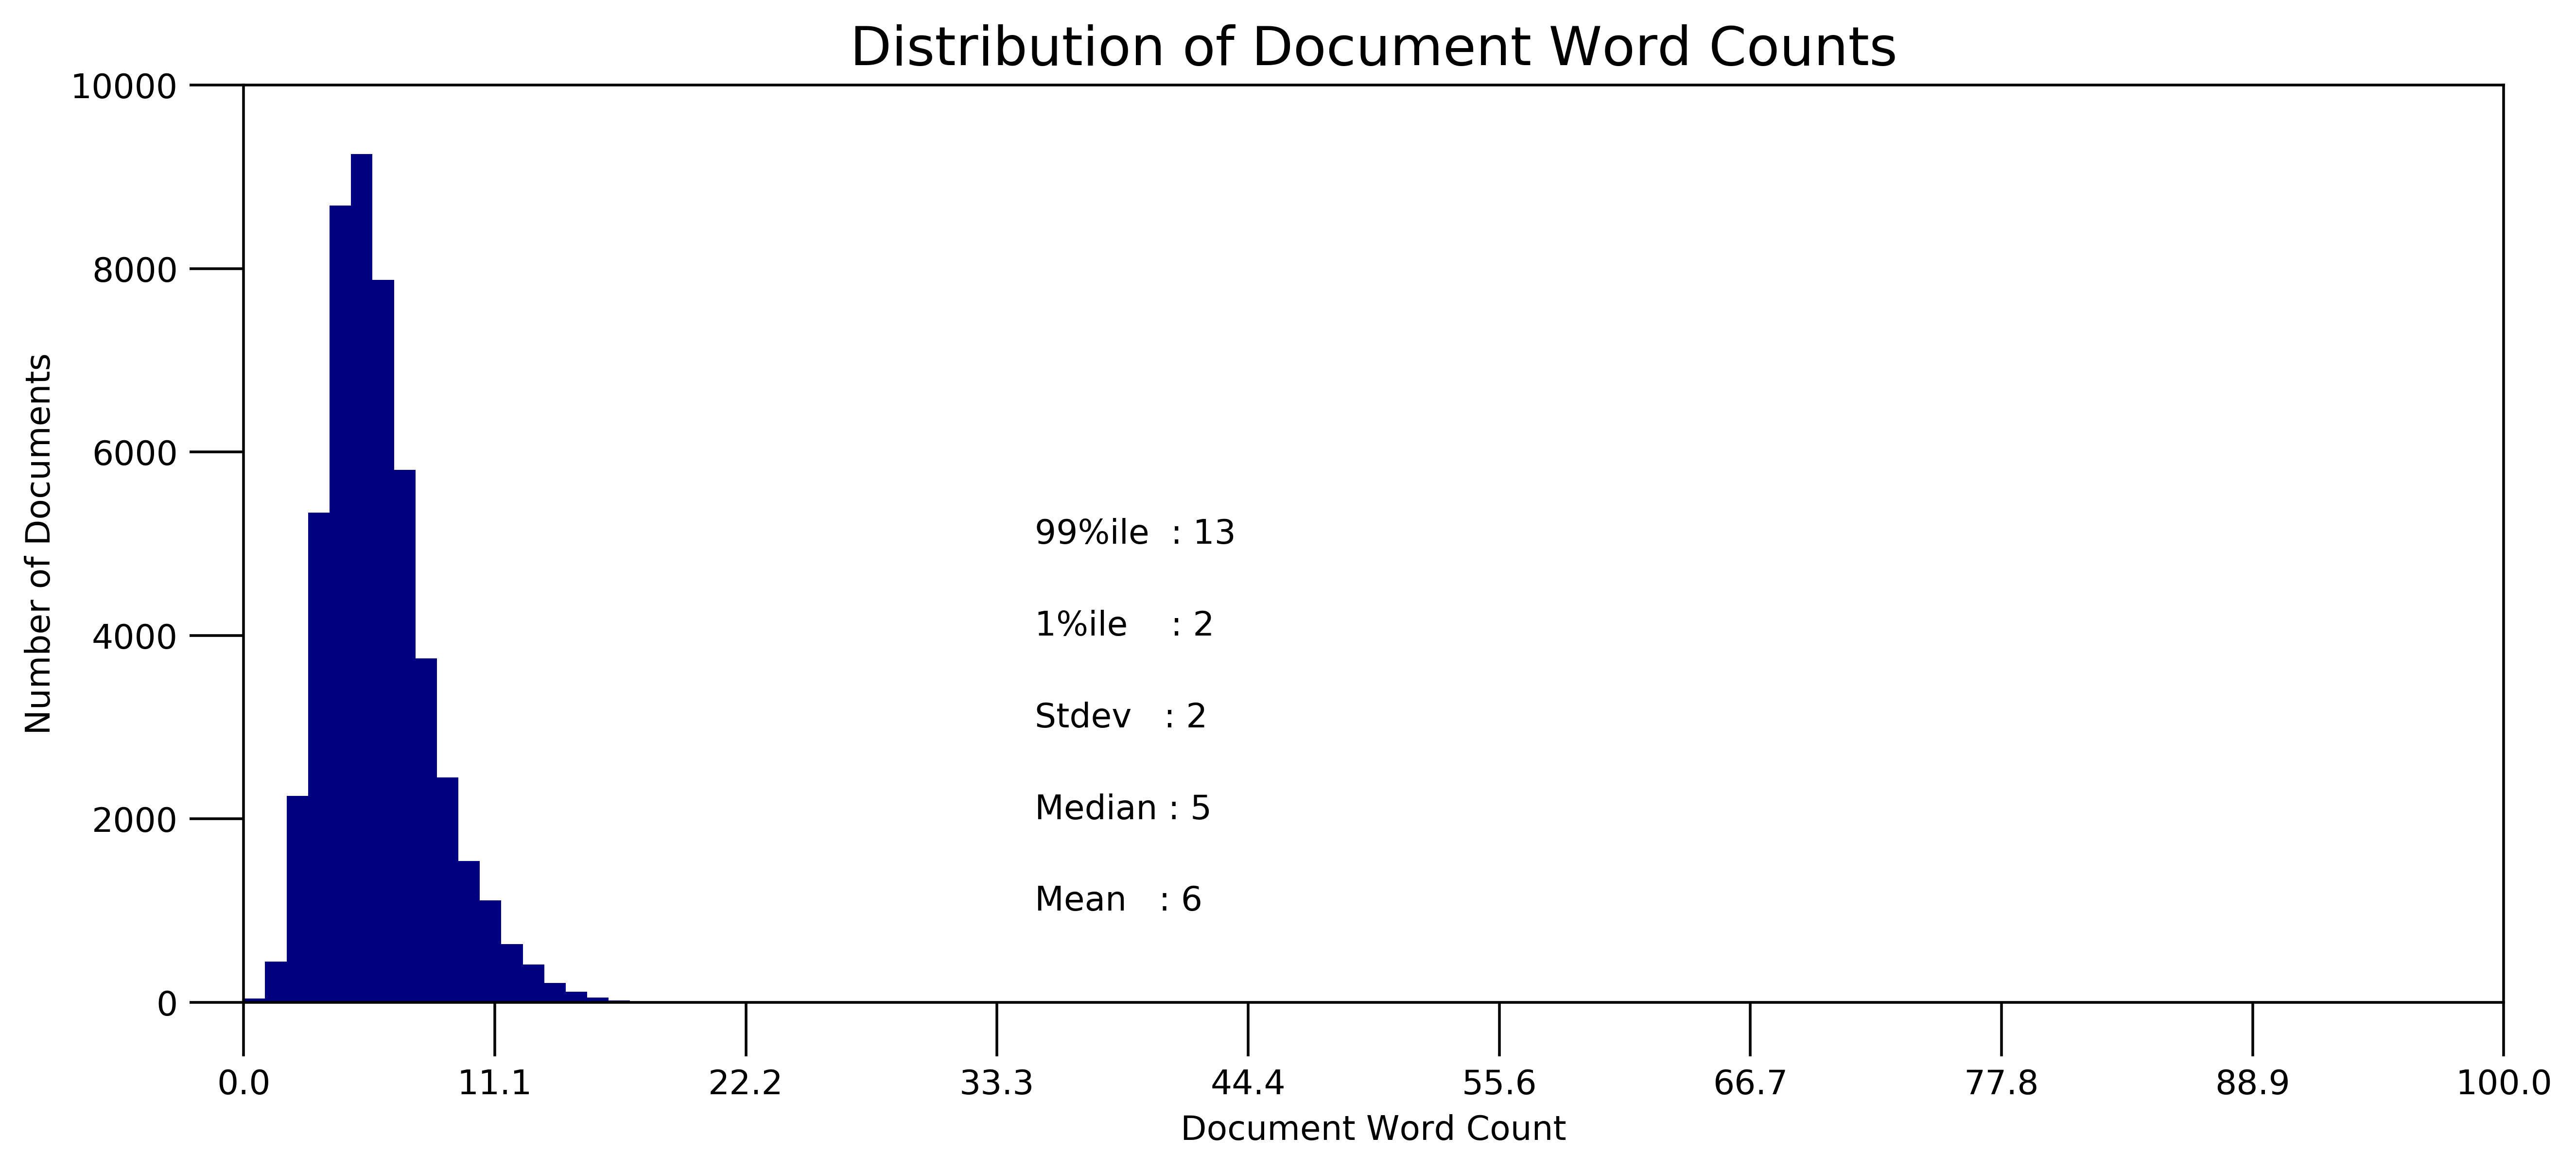

In [13]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(12,5), dpi=500)
plt.hist(doc_lens, bins = 20, color='navy')
plt.text(35, 1000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(35,  2000, "Median : " + str(round(np.median(doc_lens))))
plt.text(35,  3000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(35,  4000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(35,  5000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,10))
plt.yticks(np.linspace(0,10000,6))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=16))
plt.show()

In [14]:
import seaborn as sns
import matplotlib.colors as mcolors

C:\Users\Sindhoor\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


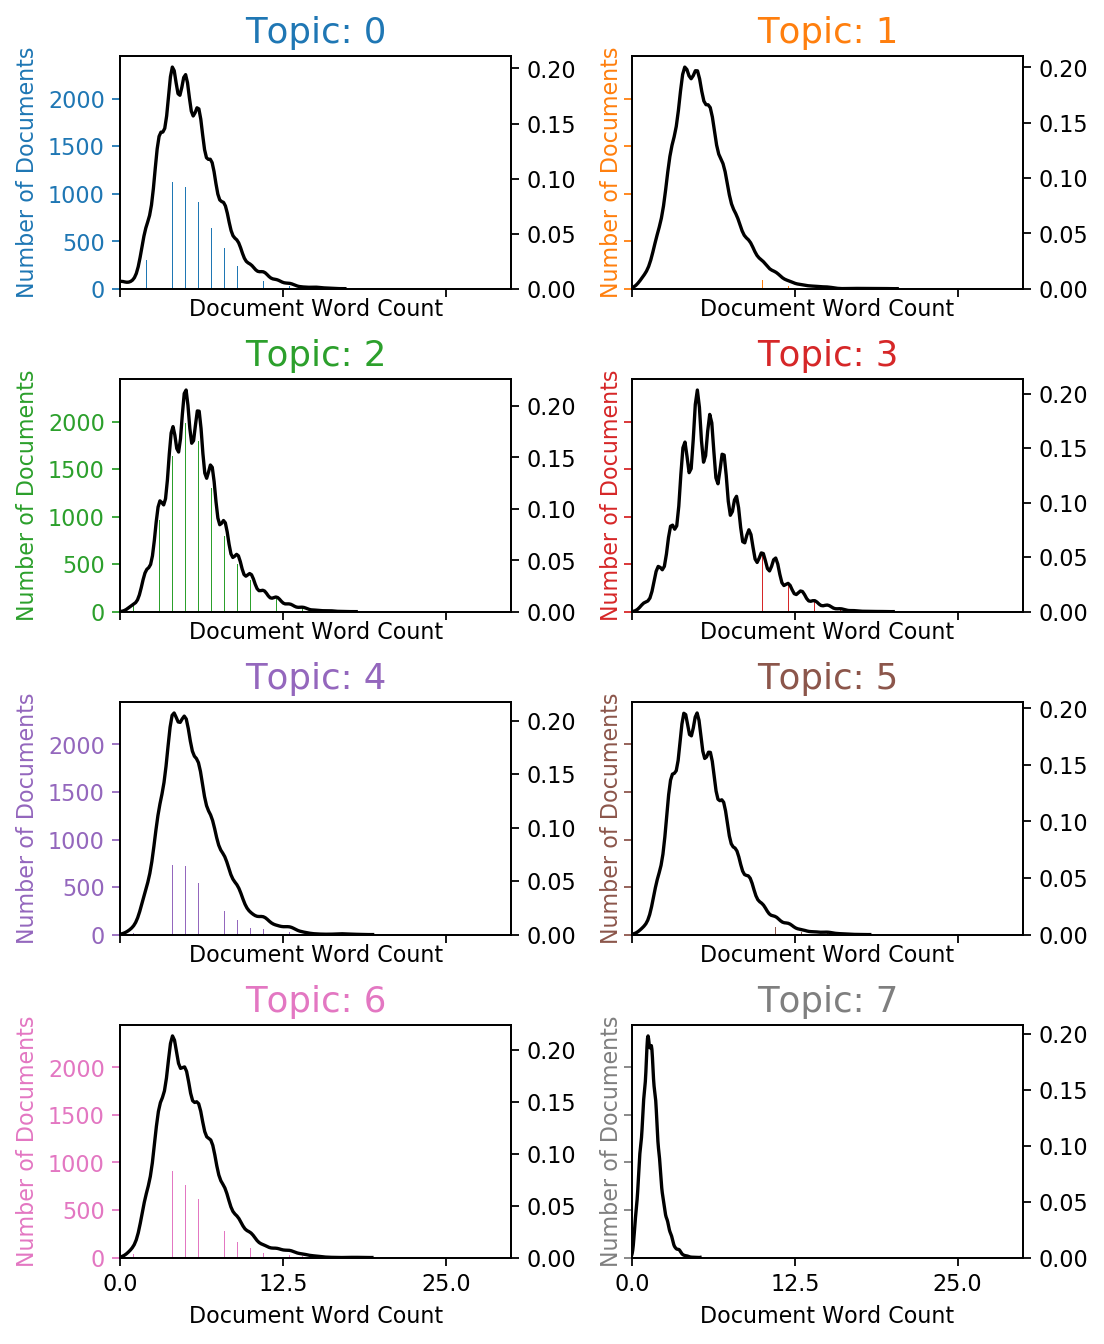

In [15]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(4,2,figsize=(7,9), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,9))
#fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [16]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

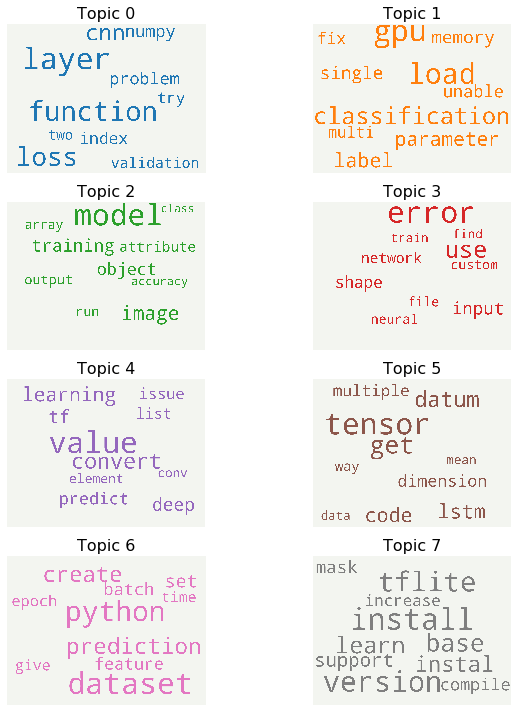

In [17]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='#f3f5f0',
                  width=2000,
                  height=1500,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

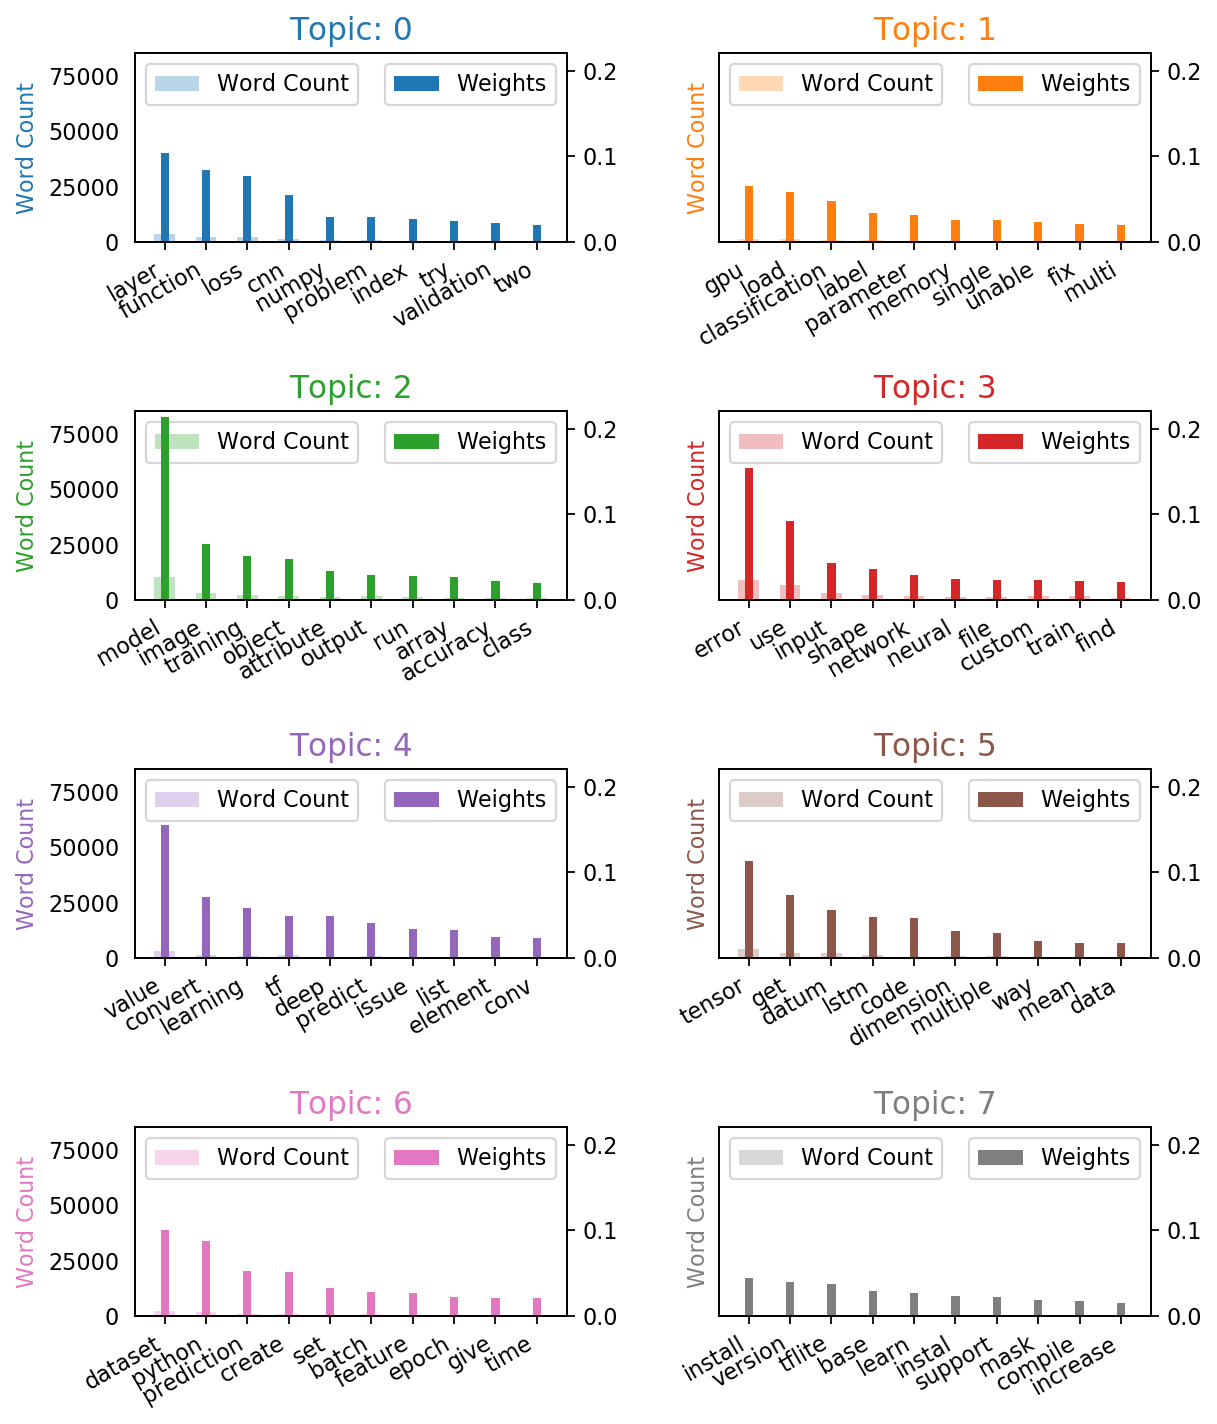

In [29]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
        
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(7.8, 9), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.220); ax.set_ylim(0, 85000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=14)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    
fig.tight_layout(w_pad=2)    
#fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

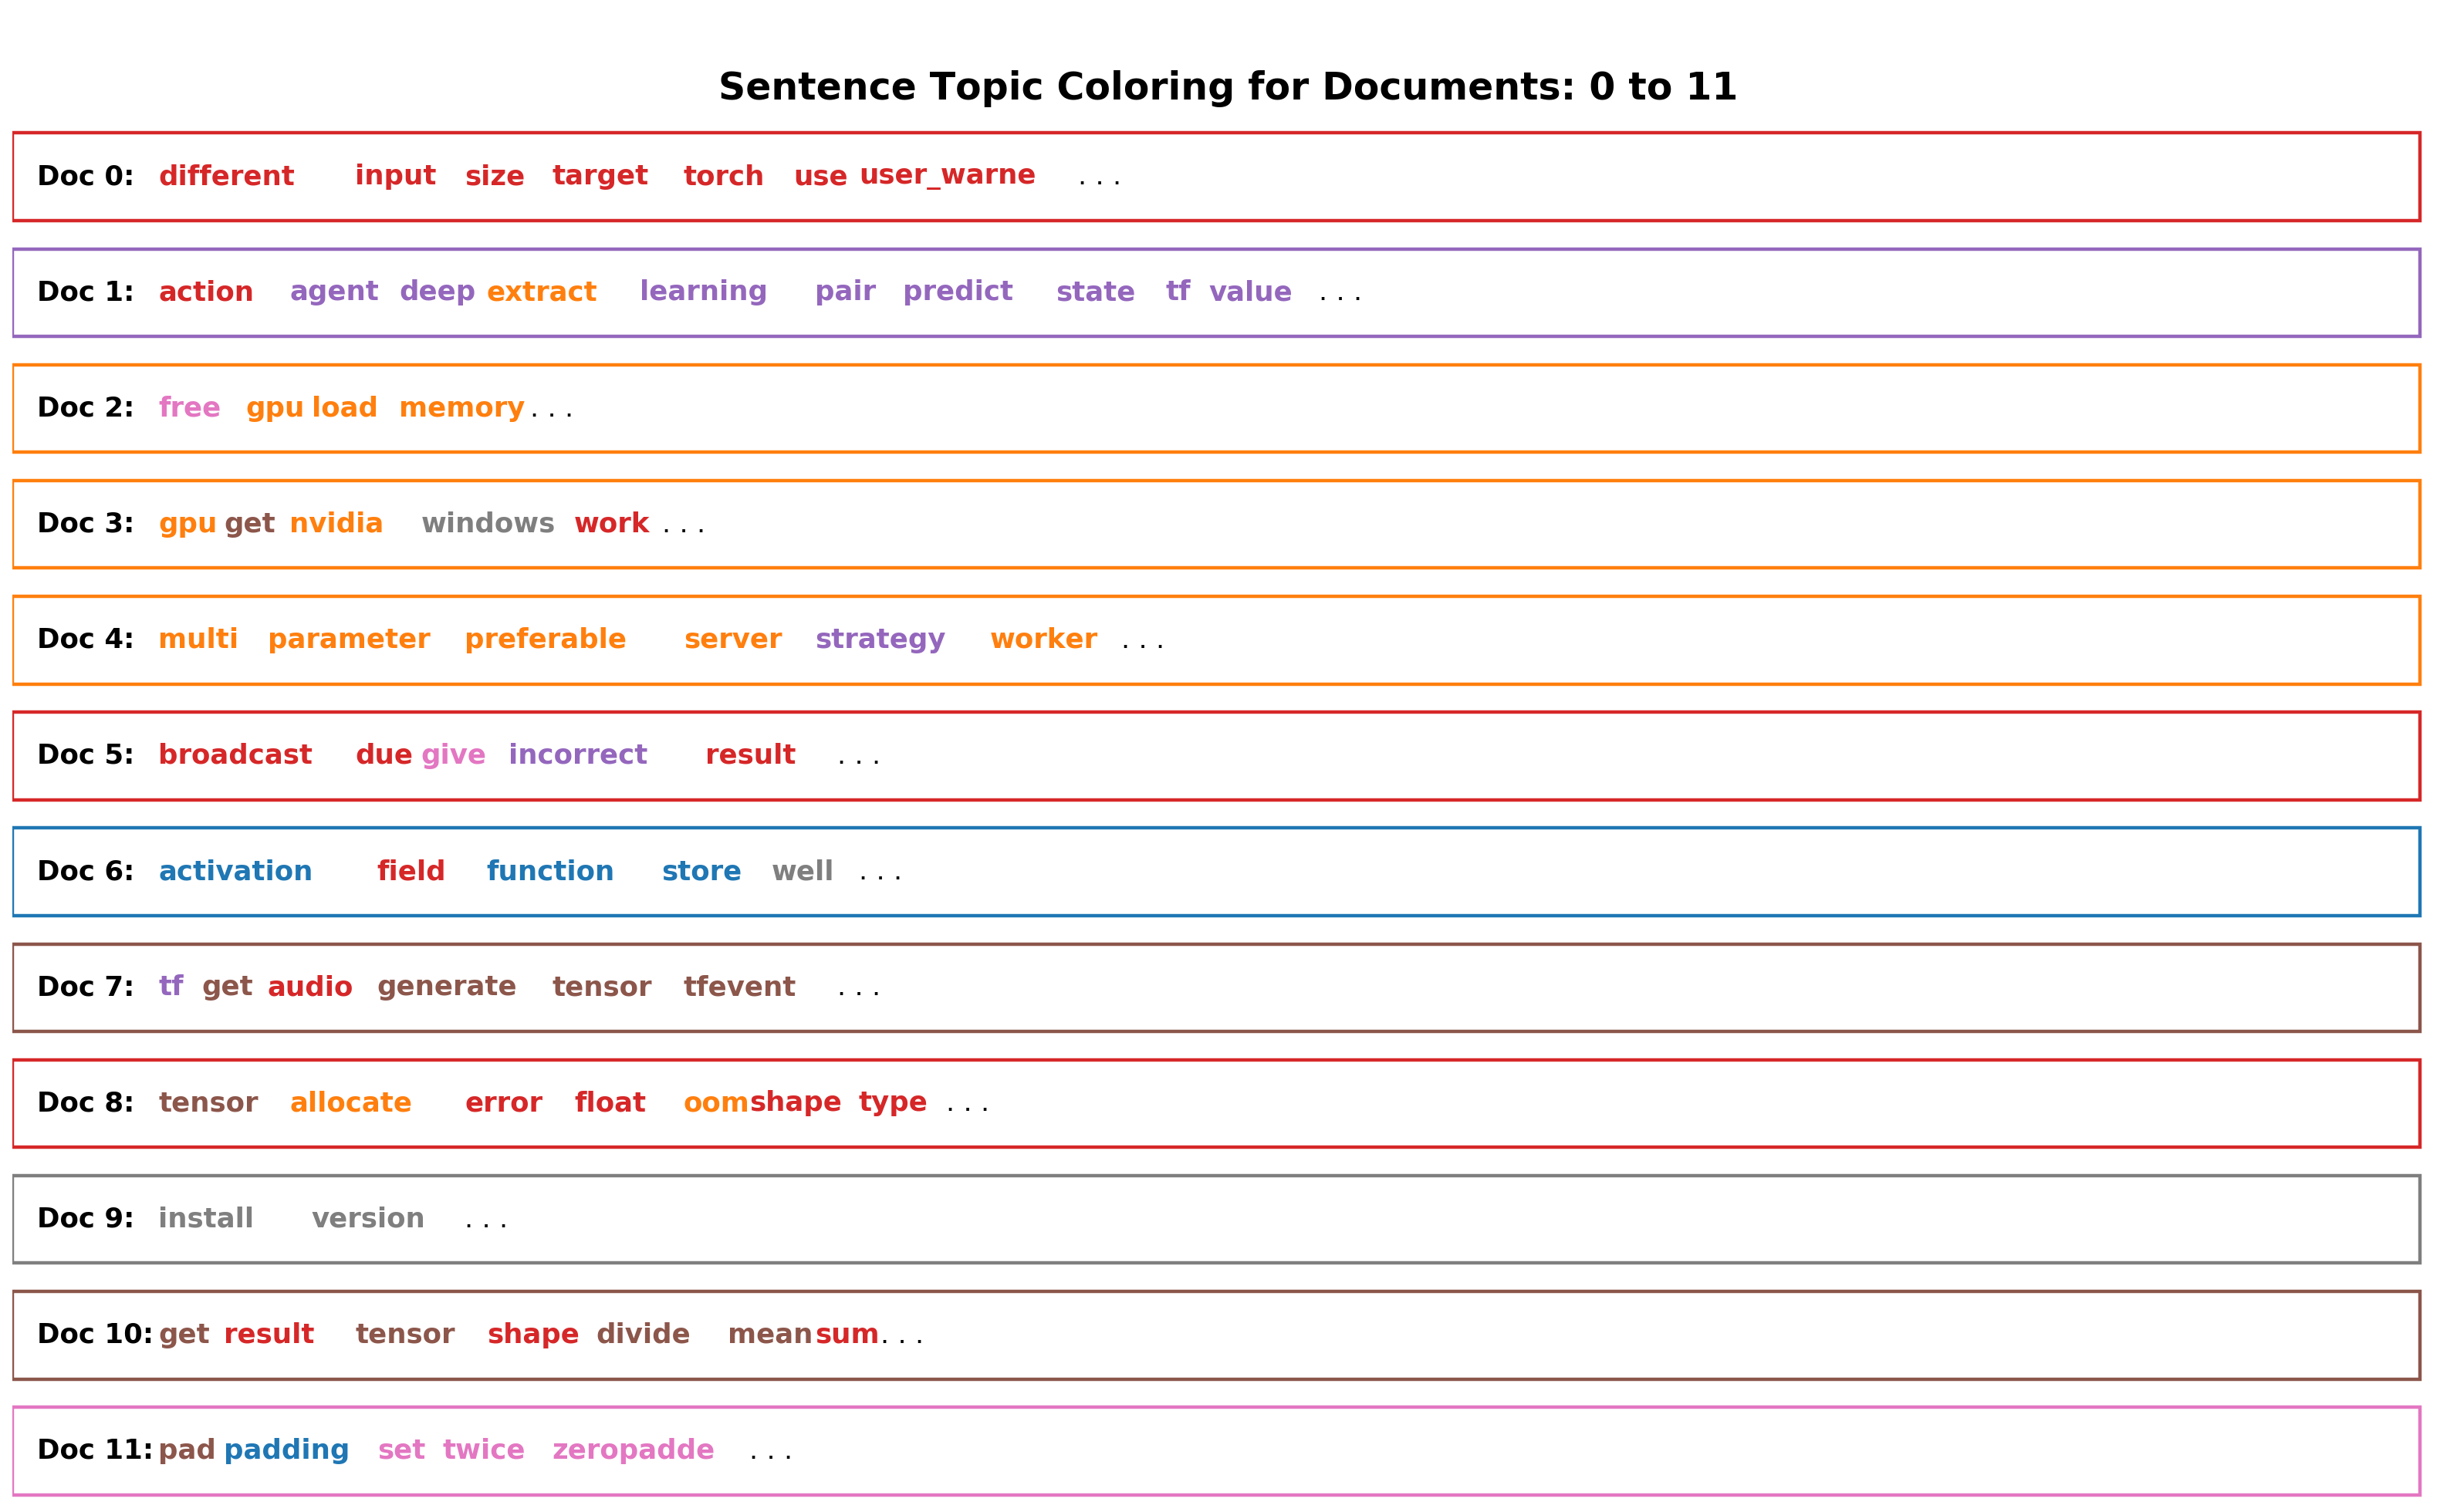

In [19]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)
            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [20]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]


df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

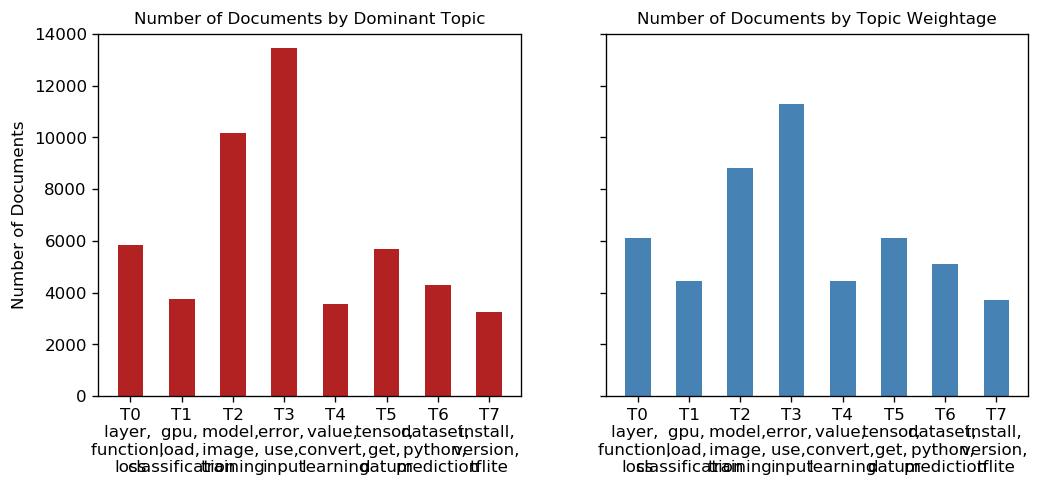

In [21]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'T'+ str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 14000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [30]:
df_dominant_topic_in_each_doc

,Dominant_Topic,count
0,0,5832
1,1,3757
2,2,10172
3,3,13449
4,4,3540
5,5,5673
6,6,4312
7,7,3264


# Generation of Topics as Clusters using T-SNE

In [31]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])
    
    # Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]
# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 34598 samples in 0.099s...


C:\Users\Sindhoor\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
C:\Users\Sindhoor\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


[t-SNE] Computed neighbors for 34598 samples in 3.326s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34598
[t-SNE] Computed conditional probabilities for sample 2000 / 34598
[t-SNE] Computed conditional probabilities for sample 3000 / 34598
[t-SNE] Computed conditional probabilities for sample 4000 / 34598
[t-SNE] Computed conditional probabilities for sample 5000 / 34598
[t-SNE] Computed conditional probabilities for sample 6000 / 34598
[t-SNE] Computed conditional probabilities for sample 7000 / 34598
[t-SNE] Computed conditional probabilities for sample 8000 / 34598
[t-SNE] Computed conditional probabilities for sample 9000 / 34598
[t-SNE] Computed conditional probabilities for sample 10000 / 34598
[t-SNE] Computed conditional probabilities for sample 11000 / 34598
[t-SNE] Computed conditional probabilities for sample 12000 / 34598
[t-SNE] Computed conditional probabilities for sample 13000 / 34598
[t-SNE] Computed conditional probabilities for sample 14000 / 34598

C:\Users\Sindhoor\Anaconda3\lib\site-packages\scipy\linalg\decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
C:\Users\Sindhoor\Anaconda3\lib\site-packages\scipy\linalg\decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.180412


C:\Users\Sindhoor\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\Sindhoor\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 1000 iterations: 1.119488


Loading BokehJS ...

# Interactive Visualization using pyLDAvis

In [24]:
!pip install pyLDAvis

import pyLDAvis.gensim_models as gensimvis
#pyLDAvis.enable_notebook()
#vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
#vis


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import pyLDAvis

In [26]:
pyLDAvis.enable_notebook()

In [27]:
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\Sindhoor\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.438472 -0.091751       1        1  24.030641
2     -0.029769  0.439574       2        1  17.740276
5      0.077360 -0.077286       3        1  12.125129
0      0.054863 -0.051572       4        1  11.891239
6      0.080841 -0.066248       5        1   9.904360
4      0.084631 -0.058198       6        1   8.829789
1      0.085672 -0.041332       7        1   8.601867
7      0.084874 -0.053187       8        1   6.876700, topic_info=            Term          Freq         Total Category  logprob  loglift
121        model  10905.000000  10905.000000  Default  30.0000  30.0000
46         error  10680.000000  10680.000000  Default  29.0000  29.0000
16         value   3956.000000   3956.000000  Default  28.0000  28.0000
5            use   6369.000000   6369.000000  Default  27.0000  27.0000
43        tensor   3949.000000   3949.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
820         open    180.927275    181.846558   Topic8  -4.6975   2.6720
257       select    178.268451    179.188011   Topic8  -4.7123   2.6719
299      package    173.047877    173.966621   Topic8  -4.7420   2.6717
1031         bad    169.000394    169.920337   Topic8  -4.7657   2.6716
474   dependency    168.603943    169.522614   Topic8  -4.7680   2.6716

[270 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2094      8  0.997477        able
306       2  0.999155    accuracy
36        4  0.998647  activation
221       4  0.997527         add
256       5  0.998861   algorithm
...     ...       ...         ...
1161      3  0.996613        word
24        1  0.999346        work
466       3  0.998081       write
160       2  0.998043       yolov
204       3  0.996974        zero

[240 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 6, 1, 7, 5, 2, 8])